In [ ]:
%pip install PyPDF2 nltk pandas
!pip install pdfminer.six
!pip install enchant

In [2]:
import PyPDF2
import nltk
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import enchant
import pdfplumber
from sklearn.model_selection import train_test_split

#nltk.download('words') -> do that only once
#nltk.download('stopwords') -> do that only once
#nltk.download("punkt") -> do that only once

In [3]:
def find_contents_page(pdf_path):
    with open(pdf_path, "rb") as file:
        pdf_reader = PyPDF2.PdfReader(file)

        start_page = 22
        end_page = 28
        end_page = min(end_page, len(pdf_reader.pages))
        contents_page = ""
        for page_num in range(start_page, end_page):
            page_text = pdf_reader.pages[page_num].extract_text()
            lines = page_text.split('\n')
            page_text = ' '.join(lines)
            contents_page += page_text
        if not contents_page:
            return "Specified pages not found in the PDF"

        return contents_page


In [4]:
def create_csv(sections):
    data = []
    for match in sections:
        chapter = match[0]
        title = match[1]
        page = match[2]

        data.append({"Chapter": chapter, "Title": title, "Page": page})
    df = pd.concat([pd.DataFrame([section]) for section in data], ignore_index=True)

    return df

In [5]:
def extract_sections(contents_text):
    tokens = nltk.word_tokenize(contents_text)
    matches = re.findall(r"(\d+\.\d+)\s+(.*?)\s+(\d+)", contents_text)

    return matches

In [6]:
# Replace 'OS_Main book.pdf' with the path to your PDF file
pdf_path = "Books/OS_Main book.pdf"
contents_page_text = find_contents_page(pdf_path)

In [7]:
pdf_reader = PyPDF2.PdfReader(pdf_path)
sections = extract_sections(contents_page_text)

In [8]:
sections

[('1.1', 'WhatOperating SystemsDo', '4'),
 ('1.2', 'Computer-SystemOrganization', '7'),
 ('1.3', 'Computer-SystemArchitecture', '15'),
 ('1.4', 'Operating-SystemOperations', '21'),
 ('1.5', 'Resource Management', '27'),
 ('1.6', 'Security and Protection', '33'),
 ('1.7', 'Virtualization', '341'),
 ('1.9', 'KernelDataStructures', '36'),
 ('1.10', 'ComputingEnvironments', '40'),
 ('1.11', 'Free andOpen-Source Operating Systems', '46'),
 ('2.1', 'Operating-SystemServices', '55'),
 ('2.2', 'User andOperating-System Interface', '58'),
 ('2.3', 'System Calls', '62'),
 ('2.4', 'System Services', '74'),
 ('2.5', 'Linkers and Loaders', '75'),
 ('2.6', 'Why Applications Are Operating-SystemSpecific', '772'),
 ('2.8', 'Operating-SystemStructure', '81'),
 ('2.9', 'Building andBootinganOperating System', '92'),
 ('2.10', 'Operating-SystemDebugging', '95'),
 ('2.11', 'Summary', '100'),
 ('3.1', 'Process Concept', '106'),
 ('3.2', 'Process Scheduling', '110'),
 ('3.3', 'OperationsonProcesses', '116')

In [9]:
def add_text_to_content_OLD(content_list, pdf_reader): #NOT WORKING
    new_content_list = []
    for i, (chapter_num, chapter_name, chapter_page) in enumerate(content_list):
        content_text = ""
        for page_num in range(int(chapter_page), int(chapter_page) + 50):
            page_text = pdf_reader.pages[page_num].extract_text()
            text = page_text[:50].lower()
            print(text)
            if ("exercises" in text) and ("chapter" in text):
                content_text += " " + page_text
                break
        new_content_list.append((chapter_num, chapter_name, chapter_page, content_text))
        
    return new_content_list

In [10]:
def add_text_to_content(content_list, pdf_reader): #NEW
    new_content_list = []
    upcoming_chapter = 2
    buffer = ""
    for page_number in range(29, len(pdf_reader.pages)):
        page_content = pdf_reader.pages[page_number].extract_text()
        significant_part = page_content[:50].lower()
        buffer += " " + page_content
        if f"chapter{upcoming_chapter}" in significant_part or f"chapter {upcoming_chapter} " in significant_part:
            buffer += content_list[str(upcoming_chapter-1)]
            new_content_list.append((upcoming_chapter-1, buffer, page_number))
            buffer = ""
            upcoming_chapter += 1
        elif (upcoming_chapter == 22 and 
                 f"appendices" in significant_part):
            buffer += content_list['21']
            new_content_list.append((upcoming_chapter-1, buffer, page_number))
            buffer = ""
            break
    return new_content_list

In [11]:
def pre_process_string(string_X):
    processed_string = re.sub(r'\W', ' ', str(string_X))
    processed_string = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_string)
    processed_string = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_string)
    processed_string = re.sub(r'\s+', ' ', processed_string, flags=re.I)
    processed_string = re.sub(r'^b\s+', ' ', processed_string)
    processed_string = re.sub(r'[A-Z]+[a-z]+\d+(\.\d+)?', "", processed_string)
    processed_string = re.sub(r'\d+(\.\d+)?', "", processed_string)
    processed_string = re.sub(r'\s+', ' ', processed_string, flags=re.I)
    processed_string = re.findall(r'[A-Z]+[a-z]*|[a-z]+', processed_string)
    processed_string = ' '.join(processed_string)
    return processed_string.strip()

In [12]:
def predict_label(input_string, model):
    segment_size = 300
    input_segments = split_text(input_string, segment_size)
    input_features = vectorizer.transform(input_segments).toarray()
    predicted_labels = model.predict(input_features)
    return predicted_labels

In [13]:
def get_correct_and_wrong_parts(sections):
    wrong_contents = []
    normal_contents = []
    prev_index, prev_index_dec = None, None
    prev_sec = None
    for section in sections:
        current_index, current_index_dec = section[0].split(".")
        if ((prev_index is not None) and 
            (int(current_index) == int(prev_index)) and 
            (int(current_index_dec) != int(prev_index_dec) + 1)):
            wrong_contents.append(prev_sec)
        else:
            if prev_sec is not None:
                normal_contents.append(prev_sec)

        prev_sec = section
        prev_index = current_index
        prev_index_dec = current_index_dec
    return normal_contents, wrong_contents

In [14]:
normal_contents, wrong_contents = get_correct_and_wrong_parts(sections)

In [15]:
wrong_contents 

[('1.7', 'Virtualization', '341'),
 ('2.6', 'Why Applications Are Operating-SystemSpecific', '772'),
 ('3.6', 'IPC in Message-Passing Systems', '1273'),
 ('4.5', 'Implicit Threading', '1764'),
 ('5.6', 'Real-TimeCPU Scheduling', '2275'),
 ('6.6', 'Semaphores', '2726'),
 ('7.4', 'Synchronizationin Java', '3037'),
 ('8.5', 'DeadlockPrevention', '3278'),
 ('9.5', 'Swapping', '3769'),
 ('10.7', 'MemoryCompression', '42510'),
 ('11.5', 'StorageDevice Management', '46311'),
 ('12.5', 'TransformingI/O Requeststo Hardware Operations', '51612'),
 ('13.4', 'Protection', '55013'),
 ('14.6', 'Efficiency and Performance', '58214'),
 ('15.6', 'RemoteFile Systems', '60515'),
 ('16.5', 'User Authentication', '64816'),
 ('17.8', 'Role-BasedAccess Control', '68317'),
 ('18.5', 'TypesofVMs andTheir Implementations', '71318'),
 ('19.5', 'DesignIssues in Distributed Systems', '75319'),
 ('20.7', 'File Systems', '80320'),
 ('21.4', 'TerminalServices andFast User Switching', '87421')]

In [16]:
def get_flattened_content(normal_contents):
    result = {}
    for chapter in normal_contents:
        main = chapter[0].split(".")[0]
        if main not in result.keys():
            result[main] = chapter[1]
        else:
            result[main] += " " + chapter[1]
    return result

In [17]:
flattened_contents = get_flattened_content(normal_contents)

In [18]:
flattened_contents

{'1': 'WhatOperating SystemsDo Computer-SystemOrganization Computer-SystemArchitecture Operating-SystemOperations Resource Management Security and Protection KernelDataStructures ComputingEnvironments Free andOpen-Source Operating Systems',
 '2': 'Operating-SystemServices User andOperating-System Interface System Calls System Services Linkers and Loaders Operating-SystemStructure Building andBootinganOperating System Operating-SystemDebugging Summary',
 '3': 'Process Concept Process Scheduling OperationsonProcesses Interprocess Communication IPC in Shared-MemorySystems Communicationin Client– ServerSystems Summary',
 '4': 'Overview Multicore Programming Multithreading Models ThreadLibraries Operating-System Examples Summary',
 '5': 'Basic Concepts Scheduling Criteria Scheduling Algorithms ThreadScheduling Multi-Processor Scheduling Algorithm Evaluation Summary',
 '6': 'Background TheCritical-Section Problem Peterson’sSolution Hardware Supportfor Synchronization MutexLocks Liveness Eval

In [19]:
contents_page_with_text = add_text_to_content(flattened_contents, pdf_reader)

In [20]:
dictionary = {"chapter":[], "words":[]}

In [21]:
for section in contents_page_with_text:
    dictionary["chapter"].append(section[0])
    dictionary["words"].append(re.sub(r'\b\w{20,}\b', '', pre_process_string(section[1]).replace(" the", " ").lower()))

In [22]:
df = pd.DataFrame(dictionary)

In [23]:
df["words_number"] = df["words"].apply(lambda x: len(x.split()))

In [24]:
df

,chapter,words,words_number
0,1,chapter introduction anoperating system is sof...,15126
1,2,operating system services characteristics co...,14240
2,3,process concept heap section time stack secti...,15956
3,4,overview applications can also be designed to ...,11332
4,5,basic concepts cpu o burst cycle thesuccessof ...,15196
5,6,background we can show that value of countmay...,9270
6,7,classic problems of synchronization while true...,8730
7,8,deadlock in multithreaded applications table ...,8737
8,9,background basebase limitoperating system proc...,10379
9,10,background virtual memorymemory map physical m...,16431


### Data Augmentation

In [25]:
def split_text(text, segment_size):
    words = text.split()
    segments = [words[i:i+segment_size] for i in range(0, len(words), segment_size)]
    return [' '.join(segment) for segment in segments]

In [26]:
def get_augmented_data(df, segment_size):
    augmented_data = {"chapter": [], "words": []}
    for index, row in df.iterrows():
        chapter = row["chapter"]
        words = row["words"]
        text_segments = split_text(words, segment_size)
        for segment in text_segments:
            augmented_data["chapter"].append(chapter)
            augmented_data["words"].append(segment)

    return pd.DataFrame(augmented_data).sample(frac=1)

In [27]:
augmented_df = get_augmented_data(df, 300)

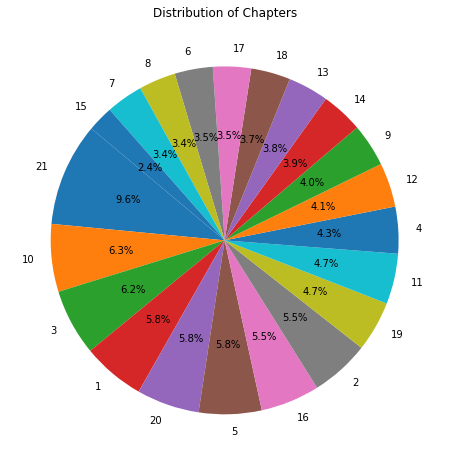

In [28]:
import matplotlib.pyplot as plt
chapter_counts = augmented_df["chapter"].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(chapter_counts, labels=chapter_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Chapters')
plt.show()

In [29]:
vectorizer = TfidfVectorizer(max_features=5000, 
                             min_df=0.05, 
                             max_df=0.85, 
                             stop_words=stopwords.words('english'))
augmented_features = vectorizer.fit_transform(augmented_df["words"]).toarray()

### Machine Learning Algorithms

In [30]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [31]:
comparison = {}

In [32]:
def get_statistics(model, X_test, y_test):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", classification_rep)

    plt.figure(figsize=(10, 6))
    pd.Series(y_pred).value_counts().sort_index().plot(kind='bar', color='darkred')
    plt.xlabel('Chapter')
    plt.ylabel('Count')
    plt.title('Distribution of Predicted Chapters')
    plt.xticks(rotation=45)
    plt.show()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(augmented_features, augmented_df["chapter"], test_size=0.2, 
                                                    random_state=0, stratify=augmented_df["chapter"])

#### Neural Network 

Accuracy: 0.78
Classification Report:
               precision    recall  f1-score   support

           1       0.58      0.70      0.64        10
           2       0.56      0.50      0.53        10
           3       0.80      0.73      0.76        11
           4       0.71      0.62      0.67         8
           5       0.67      1.00      0.80        10
           6       0.83      0.83      0.83         6
           7       0.80      0.67      0.73         6
           8       0.80      0.67      0.73         6
           9       0.78      1.00      0.88         7
          10       0.83      0.91      0.87        11
          11       1.00      0.88      0.93         8
          12       0.78      1.00      0.88         7
          13       1.00      0.86      0.92         7
          14       1.00      0.86      0.92         7
          15       1.00      0.50      0.67         4
          16       0.62      0.80      0.70        10
          17       1.00      0.83      0.9

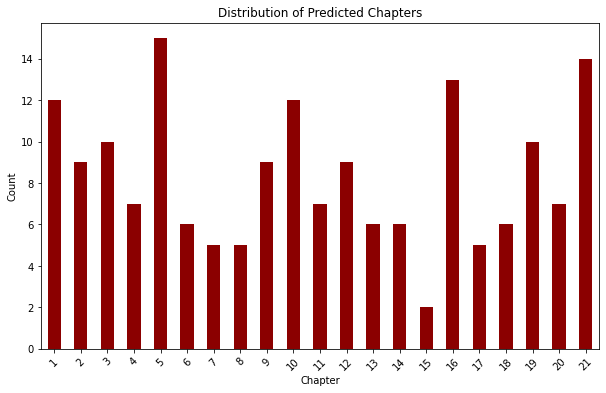

In [34]:
mlp = MLPClassifier(max_iter=10000, activation="tanh", hidden_layer_sizes=(56))
mlp.fit(X_train, y_train)
get_statistics(mlp, X_test, y_test)
comparison["MLP"] = mlp.score(X_test, y_test)

#### SVC

Accuracy: 0.71
Classification Report:
               precision    recall  f1-score   support

           1       0.54      0.70      0.61        10
           2       0.73      0.80      0.76        10
           3       0.69      0.82      0.75        11
           4       0.83      0.62      0.71         8
           5       0.67      0.80      0.73        10
           6       0.67      0.67      0.67         6
           7       0.50      0.50      0.50         6
           8       0.67      0.33      0.44         6
           9       0.64      1.00      0.78         7
          10       0.80      0.73      0.76        11
          11       0.89      1.00      0.94         8
          12       0.67      0.57      0.62         7
          13       0.67      0.86      0.75         7
          14       0.86      0.86      0.86         7
          15       1.00      0.25      0.40         4
          16       0.73      0.80      0.76        10
          17       0.80      0.67      0.7

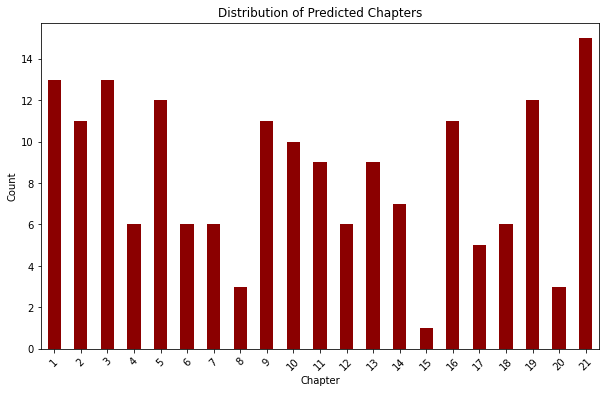

In [36]:
svc_model = SVC(kernel='rbf', C=1.0, gamma=0.9)
svc_model.fit(X_train, y_train)
get_statistics(svc_model, X_test, y_test)
comparison["SVC"] = svc_model.score(X_test, y_test)

#### Random Forest

c:\users\cagin\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\cagin\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\cagin\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Accuracy: 0.71
Classification Report:
               precision    recall  f1-score   support

           1       0.46      0.60      0.52        10
           2       0.60      0.30      0.40        10
           3       0.73      0.73      0.73        11
           4       0.70      0.88      0.78         8
           5       0.64      0.70      0.67        10
           6       0.80      0.67      0.73         6
           7       0.57      0.67      0.62         6
           8       0.75      0.50      0.60         6
           9       0.86      0.86      0.86         7
          10       0.79      1.00      0.88        11
          11       0.78      0.88      0.82         8
          12       1.00      0.43      0.60         7
          13       0.71      0.71      0.71         7
          14       0.75      0.86      0.80         7
          15       0.00      0.00      0.00         4
          16       0.71      1.00      0.83        10
          17       0.80      0.67      0.7

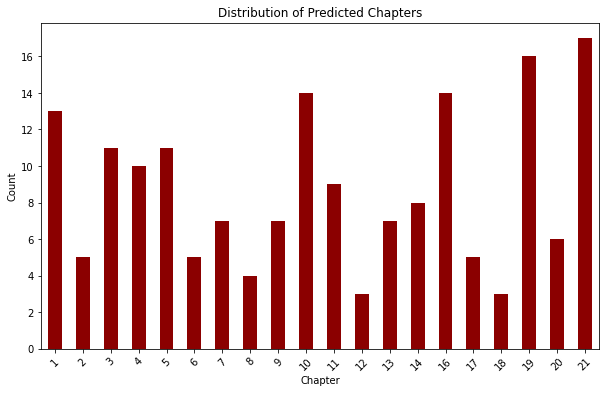

In [37]:
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
rf_classifier.fit(X_train, y_train)
get_statistics(rf_classifier, X_test, y_test)
comparison["Random Forest"] = rf_classifier.score(X_test, y_test)

#### Logistic Regression

c:\users\cagin\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\cagin\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\cagin\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Accuracy: 0.73
Classification Report:
               precision    recall  f1-score   support

           1       0.70      0.70      0.70        10
           2       0.69      0.90      0.78        10
           3       0.69      0.82      0.75        11
           4       0.71      0.62      0.67         8
           5       0.62      0.80      0.70        10
           6       0.80      0.67      0.73         6
           7       0.57      0.67      0.62         6
           8       0.67      0.33      0.44         6
           9       0.60      0.86      0.71         7
          10       0.73      0.73      0.73        11
          11       0.89      1.00      0.94         8
          12       0.67      0.57      0.62         7
          13       0.60      0.86      0.71         7
          14       1.00      0.71      0.83         7
          15       0.00      0.00      0.00         4
          16       0.73      0.80      0.76        10
          17       0.80      0.67      0.7

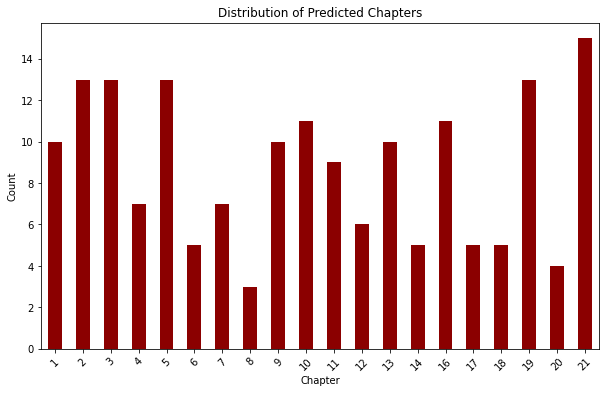

In [38]:
logreg = LogisticRegression(max_iter=1000, multi_class="multinomial")
logreg.fit(X_train, y_train)
get_statistics(logreg, X_test, y_test)
comparison["Logistic Regression"] = logreg.score(X_test, y_test)

#### Naive Bayes 

c:\users\cagin\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\cagin\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\cagin\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

           1       0.78      0.70      0.74        10
           2       0.64      0.90      0.75        10
           3       0.82      0.82      0.82        11
           4       0.86      0.75      0.80         8
           5       0.67      1.00      0.80        10
           6       0.83      0.83      0.83         6
           7       0.67      0.67      0.67         6
           8       0.75      0.50      0.60         6
           9       0.83      0.71      0.77         7
          10       0.67      0.91      0.77        11
          11       0.89      1.00      0.94         8
          12       0.83      0.71      0.77         7
          13       0.83      0.71      0.77         7
          14       0.88      1.00      0.93         7
          15       0.00      0.00      0.00         4
          16       0.78      0.70      0.74        10
          17       0.80      0.67      0.7

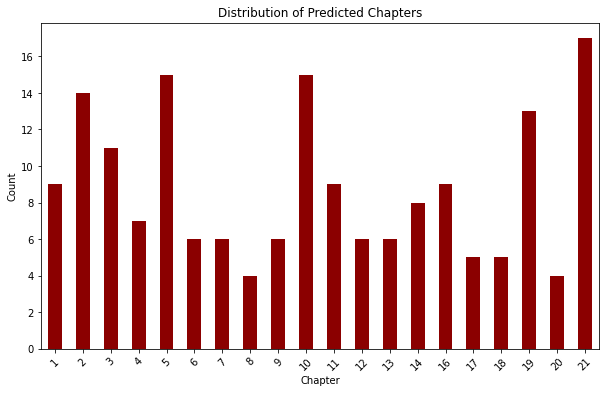

In [39]:
nb = MultinomialNB(alpha=.5)
nb.fit(X_train, y_train)
get_statistics(nb, X_test, y_test)
comparison["Naive Bayes"] = nb.score(X_test, y_test)

#### Comparison

In [40]:
comparison

{'MLP': 0.7771428571428571,
 'SVC': 0.7142857142857143,
 'Random Forest': 0.7142857142857143,
 'Logistic Regression': 0.7257142857142858,
 'Naive Bayes': 0.76}

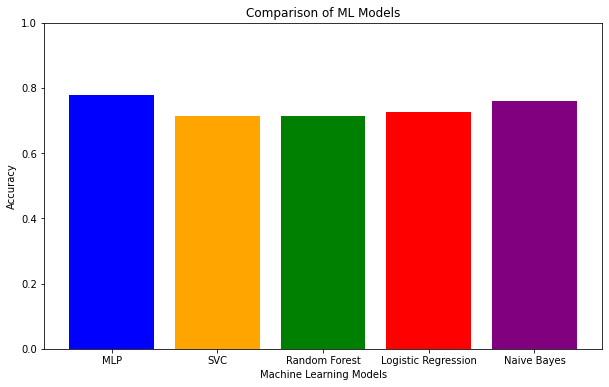

In [41]:
models = list(comparison.keys())
accuracy = list(comparison.values())

plt.figure(figsize=(10, 6))
plt.bar(models, accuracy, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title('Comparison of ML Models')
plt.xlabel('Machine Learning Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  
plt.show()

#### Sample prediction 

In [50]:
input_string = """virtual machines and their relationship to contemporary operating
systems. Included is a general description of the hardware and software
techniques that make virtualization possible. This chapter provides an
overview of computer networks and distributed systems, with a focus on
the Internet and TCP/IP."""
predicted_labels = predict_label(input_string, logreg)
print("Predicted Labels:", predicted_labels)

Predicted Labels: [18]
